# Individual Analysis of Online Anomaly Detectors with PV Datasets 

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.dates as mdates
from pathlib import Path
import re
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve

from concurrent.futures import ThreadPoolExecutor, as_completed



In [ ]:
BEST_PARAMS_FIXED_WINDOW=pd.array([
       "OnlineBootKNN_60_{'algorithm': 'brute', 'alpha': 0.05, 'chunk_size': 240, 'dmetric': 'cityblock', 'ensemble_size': 240, 'n_jobs': -1, 'transf': 'ZNORM'}",
       "SWKNN_60_{'k': 1, 'k_is_max': False, 'max_node_size': 20, 'metric': 'cityblock', 'min_node_size': 5, 'split_sampling': 5}",
       "SWKNN_240_{'k': 10, 'k_is_max': False, 'max_node_size': 20, 'metric': 'cityblock', 'min_node_size': 5, 'split_sampling': 5}",
       "SWKNN_240_{'k': 50, 'k_is_max': False, 'max_node_size': 20, 'metric': 'cityblock', 'min_node_size': 5, 'split_sampling': 5}"],
      dtype=object)


In [ ]:
PARAMS=BEST_PARAMS_FIXED_WINDOW

In [3]:

# Get the path to the current script
current_dir = Path.cwd()

# Go one level up
current_dir = current_dir.parent

DATA_PATH_AB = current_dir / 'datasets' / 'processed_ablation'


# Define dataset paths
dataset_paths = [
    DATA_PATH_AB / 'processed_server22_A1',
    DATA_PATH_AB / 'processed_server22_A2',
    DATA_PATH_AB / 'processed_server22_A3',
    DATA_PATH_AB / 'processed_server21_A4',
    DATA_PATH_AB / 'processed_server21_A5',
    DATA_PATH_AB / 'processed_L40S02_A6',
    DATA_PATH_AB / 'processed_server18_A7',
    DATA_PATH_AB / 'processed_server18_A8',
    DATA_PATH_AB / 'processed_server18_A9',
    DATA_PATH_AB / 'processed_server21_A5',
    DATA_PATH_AB / 'processed_server21_A6',
]

# Define dataset paths
dataset_paths = [
    DATA_PATH_AB / 'processed_server21_A6',
    DATA_PATH_AB / 'processed_L40S02_A6',
]

def process_file(file_path, scenario):
    try:
        print(f"Processing file: {file_path.name} for scenario: {scenario}") # Now printing the scenario
        df = pd.read_excel(file_path)
        df["window_size"] = file_path.name.split("_")[-1].replace(".xlsx", "")
        df["method_window_and_param"] = df.method + "_" + df.window_size + "_" + df.param
        #df = df[df['method_window_and_param'].isin(PARAMS)]

        # Example: Add a 'scenario' column to the DataFrame
        df['scenario'] = scenario

        return df if not df.empty else None
    except Exception as e:
        print(f"Error processing {file_path.name}: {e}")
        return None

def process_path(path):
    SCENARIO = path.name.split("_")[-1]
    print(f"Processing path: {path.name}")
    if not path.is_dir():
        return []
    
    files = [f for f in path.iterdir() if f.suffix == '.xlsx' and f.name.startswith('A')]
    print(f"Total Files for the Scenario {SCENARIO}: {len(files)}")
    
    dfs = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_file, file, SCENARIO) for file in files]
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                dfs.append(result)
    return dfs

# Main execution
all_dfs = []
for dataset_path in dataset_paths:
    all_dfs.extend(process_path(dataset_path))

# Concatenate all DataFrames at once
concatenated_df = pd.concat(all_dfs, ignore_index=True)



Processing path: processed_server21_A6
Total Files for the Scenario A6: 9
Processing file: A6_results_ablation_iter_0_pv_ds_ws_120.xlsx for scenario: A6
Processing file: A6_results_ablation_iter_0_pv_ds_ws_240.xlsx for scenario: A6
Processing file: A6_results_ablation_iter_0_pv_ds_ws_60.xlsx for scenario: A6
Processing file: A6_results_ablation_iter_1_pv_ds_ws_120.xlsx for scenario: A6
Processing file: A6_results_ablation_iter_1_pv_ds_ws_240.xlsx for scenario: A6
Processing file: A6_results_ablation_iter_1_pv_ds_ws_60.xlsx for scenario: A6
Processing file: A6_results_ablation_iter_2_pv_ds_ws_120.xlsx for scenario: A6
Processing file: A6_results_ablation_iter_2_pv_ds_ws_240.xlsx for scenario: A6
Processing file: A6_results_ablation_iter_2_pv_ds_ws_60.xlsx for scenario: A6
Processing path: processed_L40S02_A6
Total Files for the Scenario A6: 9
Processing file: A6_results_iter_0_pv_ds_ws_120.xlsx for scenario: A6
Processing file: A6_results_iter_0_pv_ds_ws_240.xlsx for scenario: A6
Proces

In [28]:
SCENARIO = concatenated_df['scenario'].unique()[0] 
SCENARIO

'A6'

In [5]:
concatenated_df["timestamp"] = pd.to_datetime(concatenated_df["timestamp"])
concatenated_df["cleaned_score"] = concatenated_df["cleaned_score"].astype('float64')


In [56]:
regex_filter = r"OnlineBootMGV|LODA|Py"
filtered_data = concatenated_df[~concatenated_df['method'].str.contains(regex_filter, regex=True)]
#filtered_data = filtered_data[filtered_data['method'].str.contains("std_p")]
#filtered_data = filtered_data[filtered_data['method'].str.contains("None|FOD|SOD|DIL|QUANT")]
#filtered_data = filtered_data[filtered_data['method'].str.contains("QUANT")]
#filtered_data = filtered_data[filtered_data.method.str.contains("OnlineBootGP|OnlineBootKNN")]


filtered_data = concatenated_df[concatenated_df['method_window_and_param'].isin(PARAMS)]

regex_pattern = r"'k':\s*(\d+)"
filtered_data['k_parameter'] = filtered_data['method_window_and_param'].str.extract(regex_pattern).replace(np.nan, "1")
filtered_data['method_window_k'] =  filtered_data['method'] +' (ws: '+ filtered_data['window_size'] +', k: '+ filtered_data['k_parameter']+')'


filtered_data["timestamp"] = pd.to_datetime(filtered_data["timestamp"])
filtered_data["cleaned_score"] = filtered_data["cleaned_score"].astype('float64')


C:\Users\nicol\AppData\Local\Temp\ipykernel_3548\2703528546.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['k_parameter'] = filtered_data['method_window_and_param'].str.extract(regex_pattern).replace(np.nan, "1")
C:\Users\nicol\AppData\Local\Temp\ipykernel_3548\2703528546.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['method_window_k'] =  filtered_data['method'] +' (ws: '+ filtered_data['window_size'] +', k: '+ filtered_data['k_parameter']+')'
C:\Users\nicol\AppData\

In [57]:
# Get the final list of unique merged combinations
method_window_and_param = filtered_data["method_window_k"].unique()
print(method_window_and_param)

['SWKNN (ws: 240, k: 10)' 'SWKNN (ws: 240, k: 50)' 'SWKNN (ws: 60, k: 1)'
 'OnlineBootKNN (ws: 60, k: 1)']


In [58]:
num_colors = len(method_window_and_param)
print("Total Hyperparameter Tuning: ", num_colors)


Total Hyperparameter Tuning:  4


In [59]:
#methods = np.array(['OnlineBootKNN','BKNN','SWKNN'], dtype=object)

In [60]:

# Define a color list (consider using a color palette from seaborn or matplotlib)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 
          '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', 
          '#17becf',"#cf17c6","#83680e"]


# Generate a list of colors corresponding to the methods
color_list = [colors[i] for i in range(num_colors)]

print(color_list)  # Display the first 10 colors

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


In [61]:
filtered_data['error_type_score'] = filtered_data['error_type_score'].fillna("No Error")
filtered_data.pivot_table(index='method_window_k', columns='error_type_score', values='cleaned_score', aggfunc='count')


C:\Users\nicol\AppData\Local\Temp\ipykernel_3548\14178589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['error_type_score'] = filtered_data['error_type_score'].fillna("No Error")


error_type_score,Array Output Assigned the First Value.,Array Output Assigned the First Value. | Infinity Output Assigned to 1e+200.,No Error
method_window_k,,,
"OnlineBootKNN (ws: 60, k: 1)",NaN,NaN,12600.0
"SWKNN (ws: 240, k: 10)",12570.0,30.0,NaN
"SWKNN (ws: 240, k: 50)",12450.0,150.0,NaN
"SWKNN (ws: 60, k: 1)",12597.0,3.0,NaN


In [62]:
iterations = filtered_data["iteration"].unique()[0:10]
iterations

array([0, 2, 1], dtype=int64)

## Individual Score of Online Anomaly Detectors with PV Datasets 

In [63]:
FONTSIZE_MAIN = 14
FONTSIZE_SEC = 13

In [65]:
# Group data by method and timestamp, calculating both the mean and std
average_results = filtered_data.groupby(['method_window_k',  'timestamp'], as_index=False).agg(
    mean_score=('cleaned_score', 'mean'),
    std_score=('cleaned_score', 'std'),
    mean_gt=('ground_truth', 'mean')
)


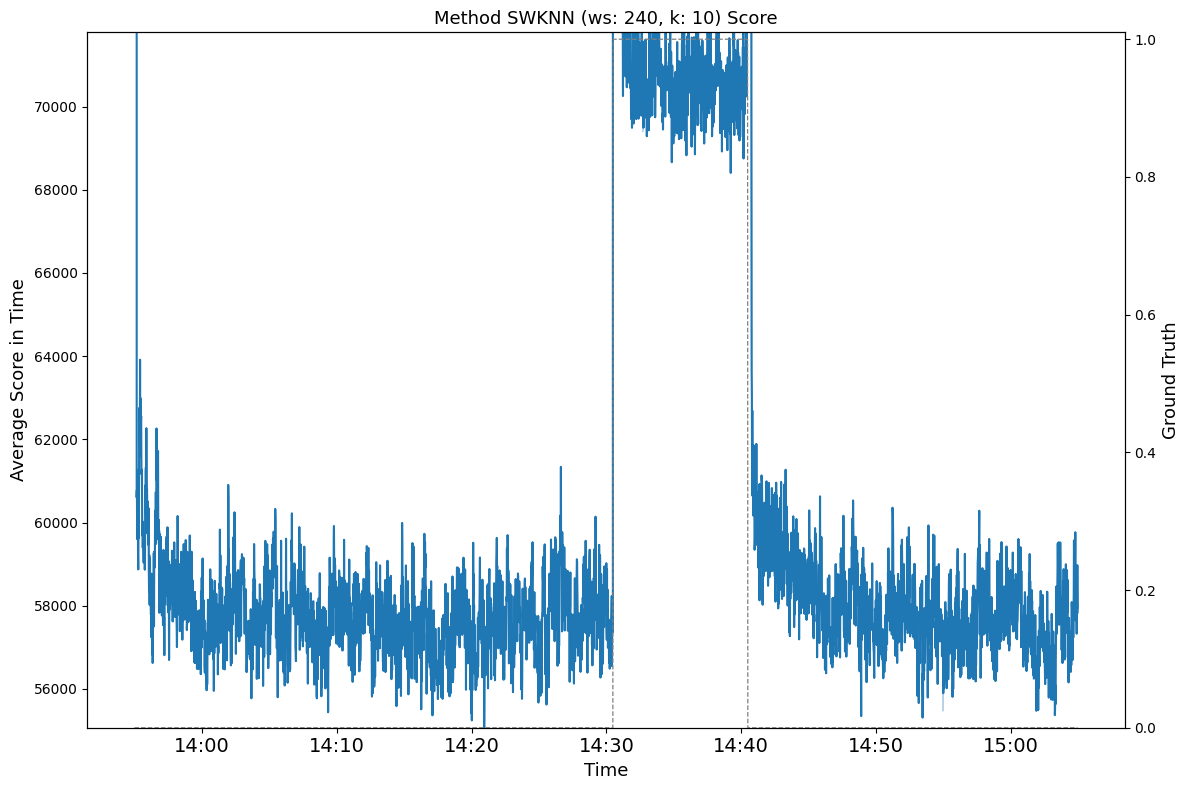

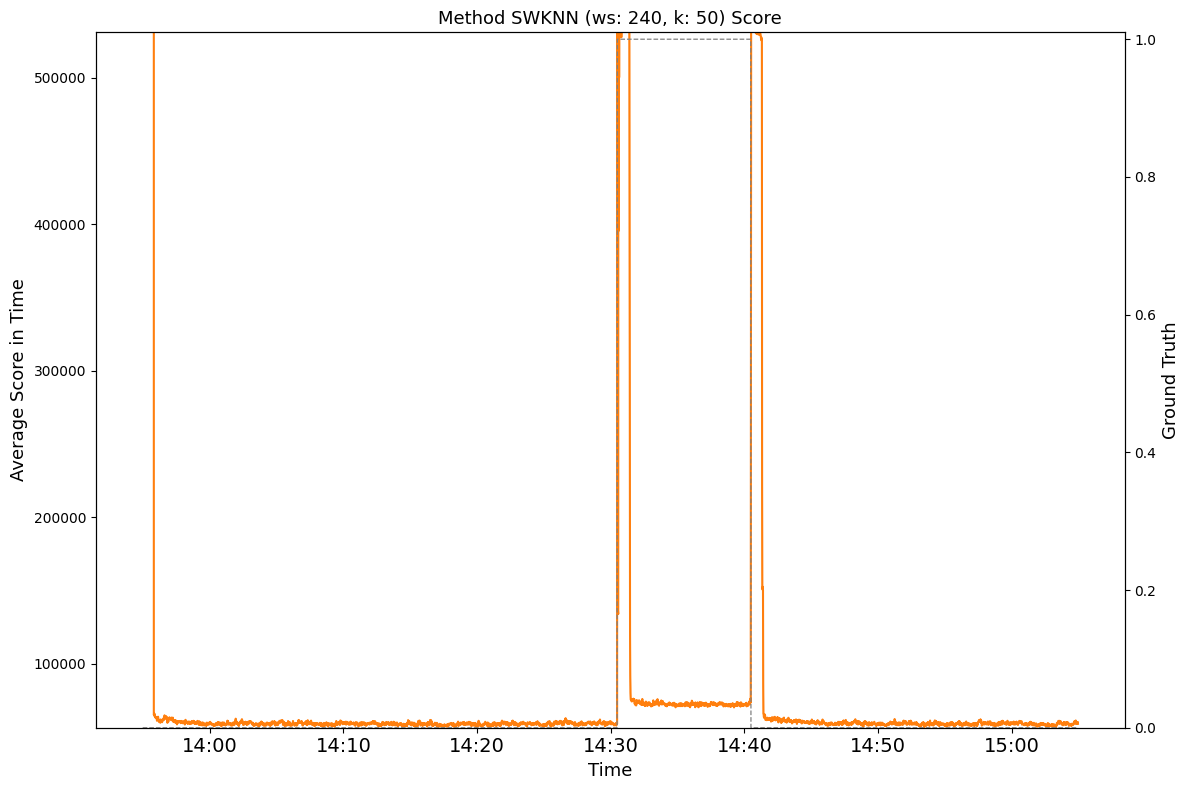

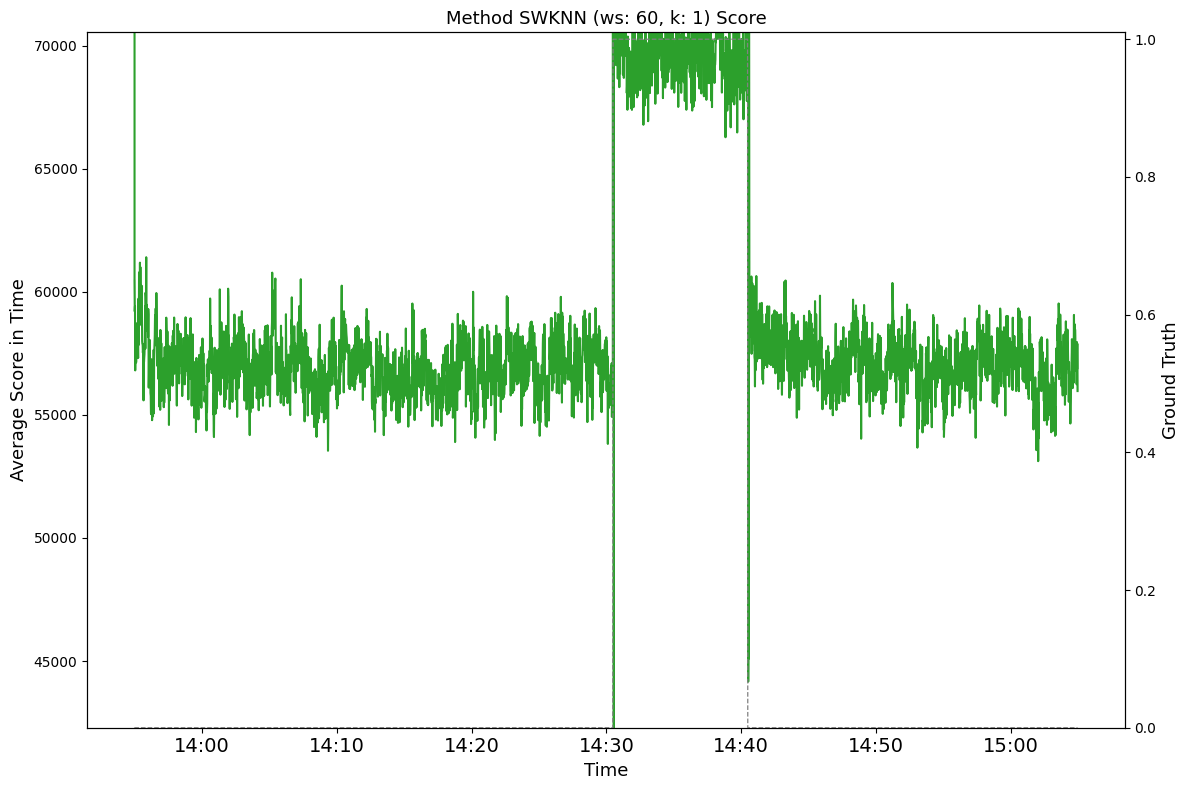

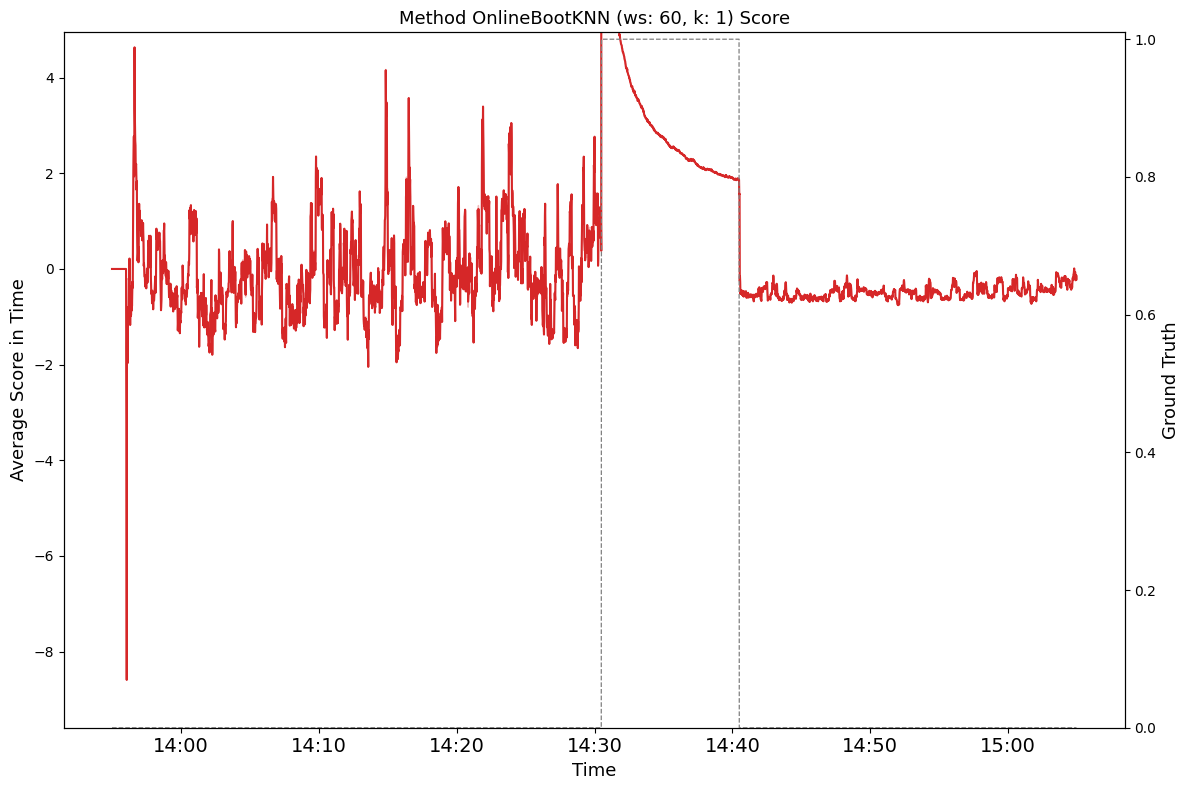

In [79]:
QUANTILE_MAX = 97
QUANTILE_MIN = 0

# Loop through methods and plot the averaged values and std
for m, color in zip(method_window_and_param, color_list):
    # Create a single figure
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Filter data for the current method
    method_data = average_results[(average_results["method_window_k"] == m)]
    
    # Plot the mean score
    ax1.plot(
        method_data['timestamp'], 
        method_data['mean_score'], 
        label=f'{m} (Averaged Iterations) with Param', 
        color=color
    )
    
    # Plot the standard deviation as a shaded area on the first axis
    ax1.fill_between(
        method_data['timestamp'], 
        method_data['mean_score'] - method_data['std_score'], 
        method_data['mean_score'] + method_data['std_score'], 
        color=color, alpha=0.3, label=f'Method {m} (± Std Dev)'
    )

    # Set labels and title for the first y-axis
    ax1.set_xlabel('Time', fontsize=FONTSIZE_SEC)
    ax1.set_ylabel('Average Score in Time', fontsize=FONTSIZE_SEC)
    ax1.set_title(f"Method {m} Score", fontsize=FONTSIZE_SEC)
    qlow, qhigh = np.percentile(method_data['mean_score'], [QUANTILE_MIN, QUANTILE_MAX]) # Calculate 25st and 75th percentiles 
    ax1.set_ylim(qlow-1, qhigh+1)  # Scale the ground truth values down (50% here) 

    # Create a second y-axis
    ax2 = ax1.twinx()
    
    # Plot the Ground Truth on the second y-axis
    ax2.plot(
        method_data['timestamp'], 
        method_data['mean_gt'], 
        label='Ground Truth', 
        color='grey', linestyle='--',
        linewidth=0.9  # Make the line very thin
    )
    
    # Set label for the second y-axis
    ax2.set_ylabel('Ground Truth', fontsize=FONTSIZE_SEC)
    
    # Adjust the second y-axis range (this is the key part to scale it visually)
    ax2.set_ylim(0, 1.01)  # Scale the ground truth values down (50% here)

    # Add legends and grid
    #ax1.legend(loc='upper left', fontsize=FONTSIZE_MAIN)
    #ax2.legend(loc='upper right', fontsize=FONTSIZE_MAIN)
    ax1.grid(False)  # Remove gridlines
    
    # Format the x-axis to show only the hours
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # Improve layout and display
    ax1.tick_params(axis='x', labelsize=FONTSIZE_MAIN)  # larger x-axis labels

    plt.xticks(rotation=45, fontsize=FONTSIZE_MAIN)
    plt.tight_layout()

    # Save the plot
    m = m.replace("(", "_").replace(")", "_").replace(",", "_").replace(":", "_").replace(" ", "")
    plt.savefig(current_dir / 'notebooks' / 'score_functions'/ f"{SCENARIO}_score_{m}.pdf", format="pdf")
    
    # Display the plot
    plt.show()


Method: SWKNN (ws: 240, k: 10), Iteration: 0
Method: SWKNN (ws: 240, k: 10), Iteration: 1
Method: SWKNN (ws: 240, k: 10), Iteration: 2


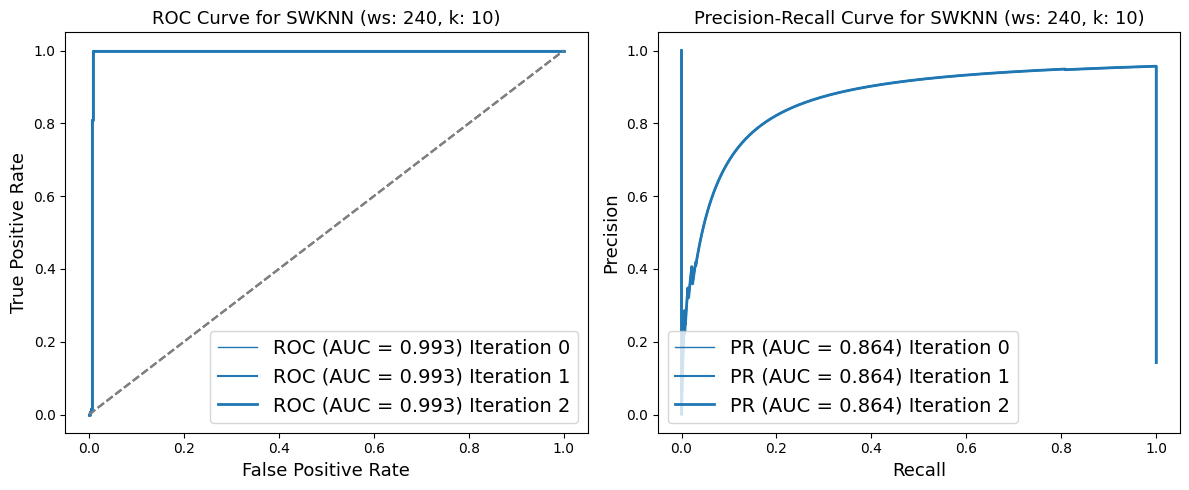

Method: SWKNN (ws: 240, k: 50), Iteration: 0
Method: SWKNN (ws: 240, k: 50), Iteration: 1
Method: SWKNN (ws: 240, k: 50), Iteration: 2


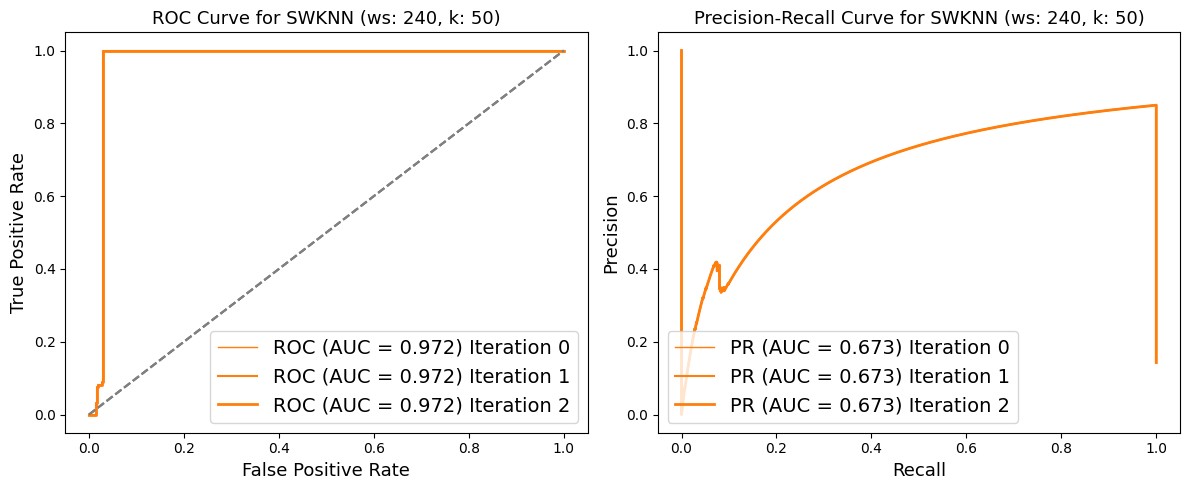

Method: SWKNN (ws: 60, k: 1), Iteration: 0
Method: SWKNN (ws: 60, k: 1), Iteration: 2
Method: SWKNN (ws: 60, k: 1), Iteration: 1


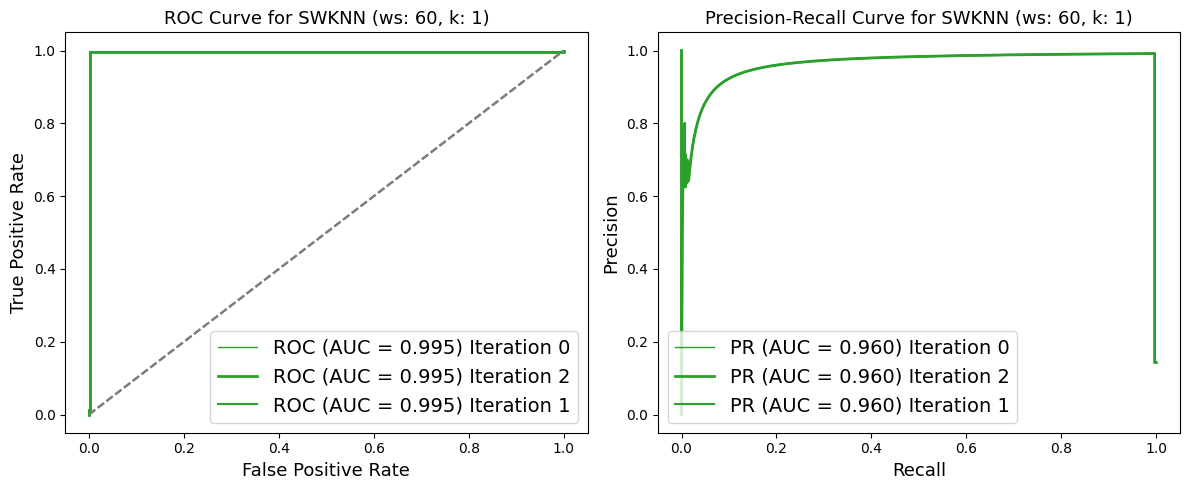

Method: OnlineBootKNN (ws: 60, k: 1), Iteration: 2
Method: OnlineBootKNN (ws: 60, k: 1), Iteration: 0
Method: OnlineBootKNN (ws: 60, k: 1), Iteration: 1


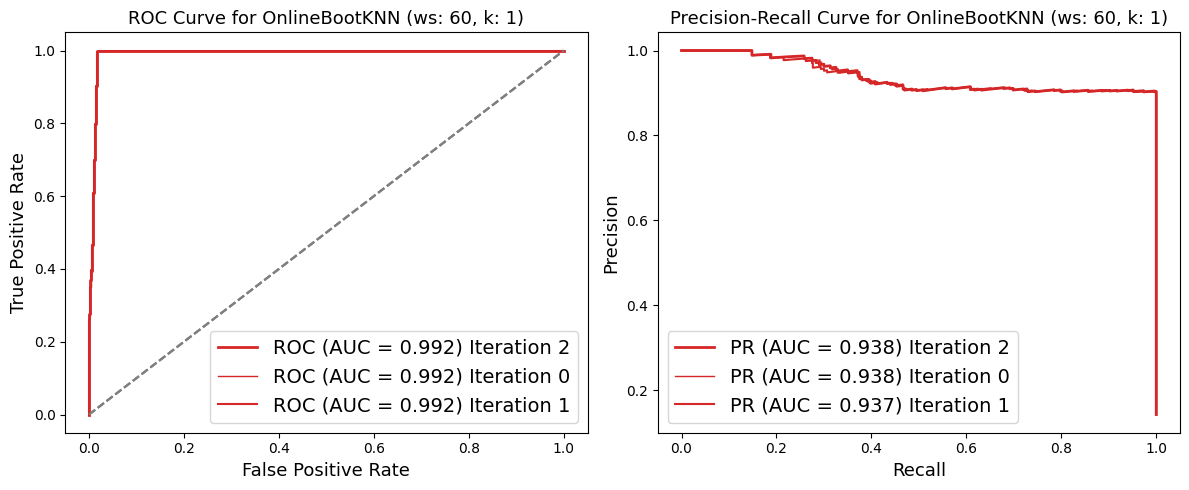

In [82]:
for m, color in zip(method_window_and_param, color_list):
    # Plot ROC Curve
    plt.figure(figsize=(12, 5))
    f_method_data = filtered_data[filtered_data['method_window_k'] == m]
    
    for i in f_method_data['iteration'].unique():
        
        print(f"Method: {m}, Iteration: {i}")
        # Filter data for the current method and iteration
        method_data = f_method_data[f_method_data['iteration'] == i]

        # Get true labels and scores
        y_true = method_data['ground_truth'].values
        y_scores = method_data['cleaned_score'].values

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Compute Precision-Recall curve and AUC
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall, precision)



        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color=color, lw=1 + i * 0.5, label=f'ROC (AUC = {roc_auc:.3f}) Iteration {i}')


        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate', fontsize=FONTSIZE_SEC)
        plt.ylabel('True Positive Rate', fontsize=FONTSIZE_SEC)
        plt.title(f'ROC Curve for {m}', fontsize=FONTSIZE_SEC)
        plt.legend(loc='lower right', fontsize=FONTSIZE_MAIN)

        # Plot Precision-Recall Curve
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, color=color, lw=1 + i * 0.5, label=f'PR (AUC = {pr_auc:.3f}) Iteration {i}')


        plt.xlabel('Recall', fontsize=FONTSIZE_SEC)
        plt.ylabel('Precision', fontsize=FONTSIZE_SEC)
        plt.title(f'Precision-Recall Curve for {m}', fontsize=FONTSIZE_SEC)
        plt.legend(loc='lower left', fontsize=FONTSIZE_MAIN)

        plt.tight_layout()
    plt.show()




In [85]:
# Group data by method and timestamp, calculating both the mean and std
average_results = filtered_data.groupby(['method_window_k',  'timestamp'], as_index=False).agg(
    mean_score=('cleaned_score', 'mean'),
    std_score=('cleaned_score', 'std'),
    mean_gt=('ground_truth', 'mean')
)
print(average_results[['timestamp', 'mean_score', 'std_score']].dtypes)

timestamp     datetime64[ns, UTC]
mean_score                float64
std_score                 float64
dtype: object


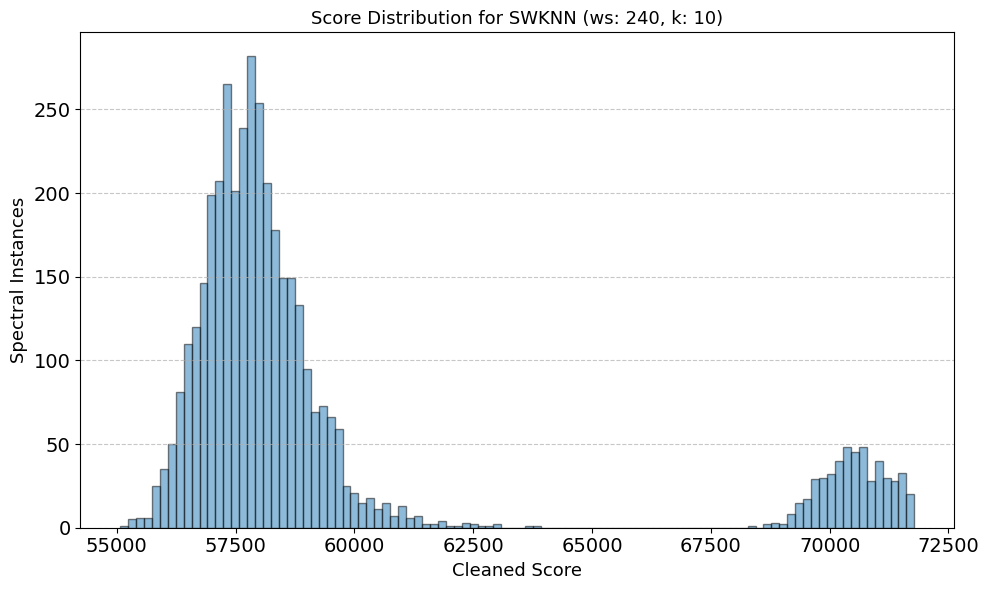

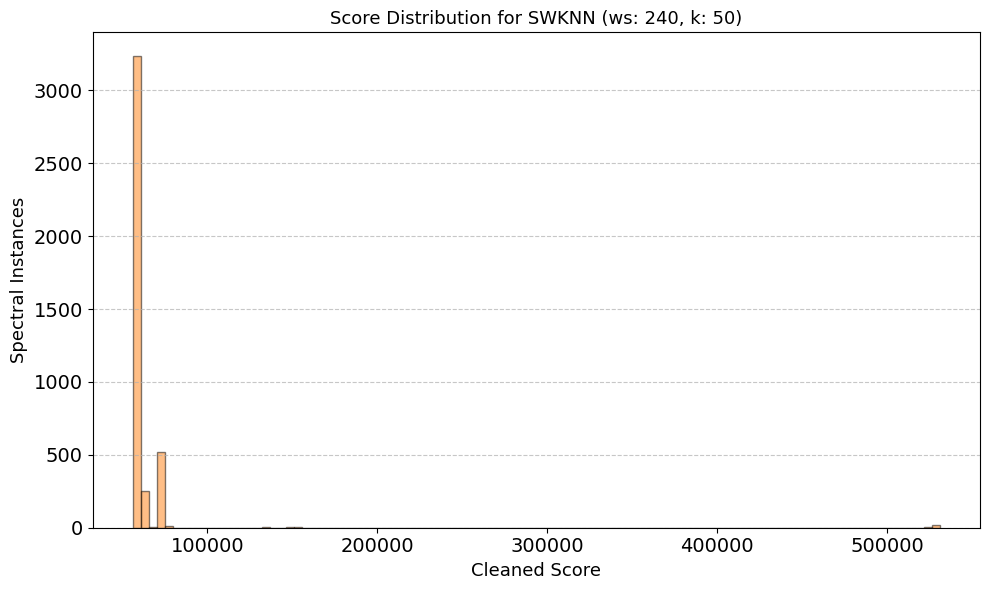

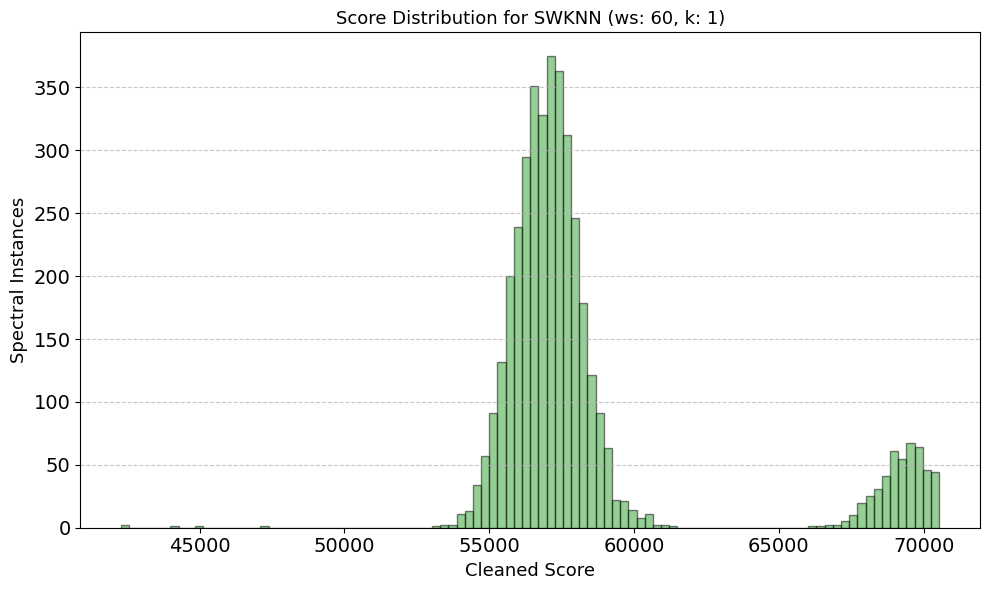

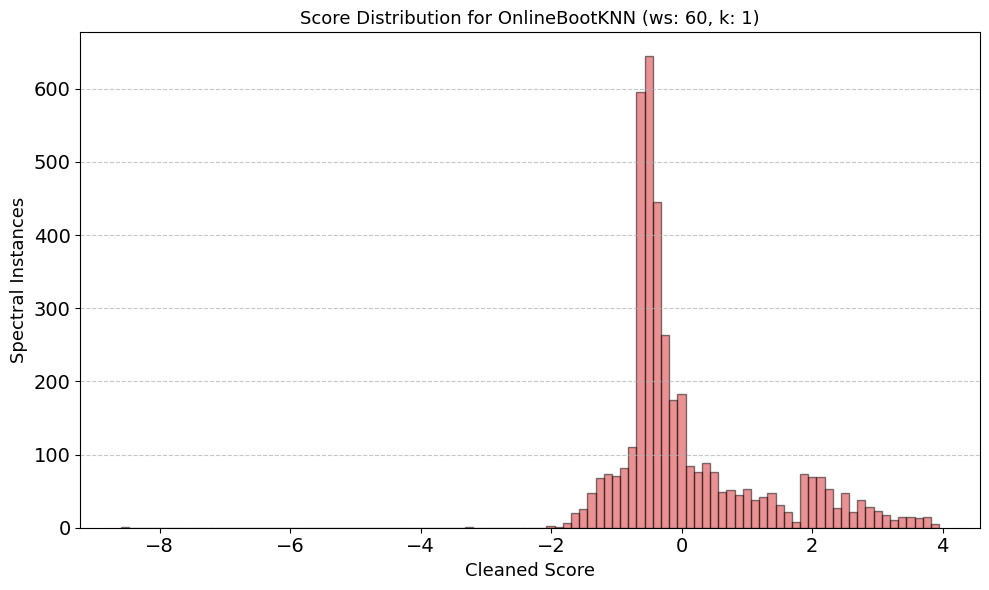

In [92]:
QUANTILE_MAX = 97
QUANTILE_MIN = 0

for m, color in zip(method_window_and_param, color_list):
    # Create a single figure for each method's histogram
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size for histograms

    # Filter data for the current method
    method_data = average_results[(average_results["method_window_k"] == m)].mean_score
    
    
    qlow, qhigh = np.percentile(method_data, [QUANTILE_MIN, QUANTILE_MAX]) # Calculate 25st and 75th percentiles  
    method_data = method_data[(method_data >= qlow) & (method_data <= qhigh)]    
    
    #method_data = method_data[:2000]    
    # Plot the histogram of scores
    ax.hist(
        method_data,
        bins=100, # Adjust number of bins as needed for your data distribution
        color=color,
        edgecolor='black', # Add edge color for better bin separation
        alpha=0.5,
        density=False, # Normalize to show probability density
        label=f'{m} Score Distribution'
    )
    
    # Add a title and labels
    ax.set_title(f"Score Distribution for {m}", fontsize=FONTSIZE_SEC)
    ax.set_xlabel('Cleaned Score', fontsize=FONTSIZE_SEC)
    ax.set_ylabel('Spectral Instances', fontsize=FONTSIZE_SEC) # Or 'Frequency' if density=False

    # Add legend and grid
    #ax.legend(fontsize=FONTSIZE_MAIN)
    ax.grid(axis='y', linestyle='--', alpha=0.7) # Grid on y-axis for readability

    # Set x-axis limits (adjust as per your score range, typically 0-1)
    #ax.set_xlim(0, 1.0) # Assuming scores are normalized between 0 and 1

    plt.xticks(fontsize=FONTSIZE_MAIN)
    plt.yticks(fontsize=FONTSIZE_MAIN)
    plt.tight_layout()

    # Save the plot (uncomment and adjust path if needed)
    #plt.savefig(f"/home/nicolas/spectral_anomaly_detector/notebooks/score_functions/{m}_score_histogram.pdf", format="pdf")

    # Display the plot
    plt.show()


## Individual Training Time of Online Anomaly Detectors with PV Datasets 

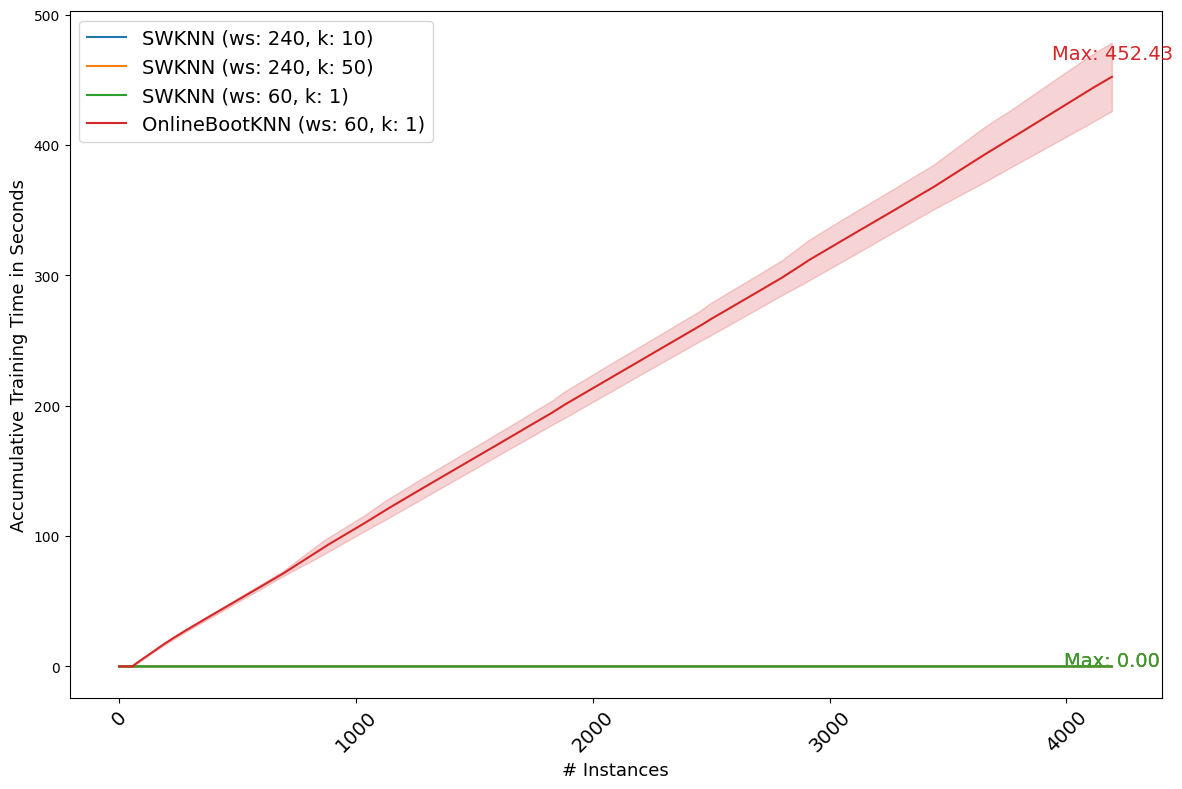

In [93]:
# Create a single figure
plt.figure(figsize=(12, 8))

# Group data by method and timestamp, calculating mean and standard deviation across iterations
grouped_data = filtered_data.groupby(['method_window_k', 'timestamp']).agg(
    mean_training_time_t=('training_time', 'mean'),
    std_training_time_t=('training_time', 'std')
).reset_index()

# Loop through methods and plot the accumulated values with shaded area
for m, color in zip(method_window_and_param, color_list):
    
    method_data = grouped_data[grouped_data["method_window_k"] == m]

    # Compute cumulative sum
    cumulative_training_time = method_data['mean_training_time_t'].expanding().sum()

    # Plot averaged training time with accumulation
    plt.plot(
        range(len(method_data['timestamp'])),  # Use the index as x-axis
        cumulative_training_time,
        label=f'{m}',
        color=color
    )

    # Plot shaded area representing standard deviation
    plt.fill_between(
        range(len(method_data['timestamp'])),  # Use the index as x-axis
        (method_data['mean_training_time_t'] - method_data['std_training_time_t']).expanding().sum(),
        (method_data['mean_training_time_t'] + method_data['std_training_time_t']).expanding().sum(),
        color=color,
        alpha=0.2
    )

    # Get max accumulated training time and timestamp
    max_time = cumulative_training_time.max()

    max_timestamp = len(method_data['timestamp'])  # Ensuring correct index

    # Format the max value properly
    formatted_max_time = f"{max_time:,.2f}"  # Adds commas and rounds to 2 decimals

    # Annotate the max value
    plt.annotate(
        f'Max: {formatted_max_time}', 
        xy=(max_timestamp, max_time), 
        xytext=(max_timestamp, max_time * 1.03),  # Adjusted for better visibility
        #arrowprops=dict(facecolor=color, arrowstyle='->'),
        fontsize=FONTSIZE_MAIN,
        color=color,
        ha='center'
    )

# Format the x-axis to show only the hours
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
# Adding labels and title
#plt.title("Training Time", fontsize=FONTSIZE_SEC)
plt.xlabel('# Instances', fontsize=FONTSIZE_SEC)
plt.ylabel('Accumulative Training Time in Seconds', fontsize=FONTSIZE_SEC)
plt.legend(loc='upper left', fontsize=FONTSIZE_MAIN)  # Place legend dynamically
plt.xticks(rotation=45, fontsize=FONTSIZE_MAIN)
#plt.grid(True, linestyle='--', alpha=0.6)  # Improve grid visibility
plt.tight_layout()

#plt.savefig(f"/home/nicolas/spectral_anomaly_detector/notebooks/img_training_and_scoring_time/{GLOBAL_SCENARIO_FILTER}_accum_training_time.pdf", format="pdf")
# Display the plot
plt.show()


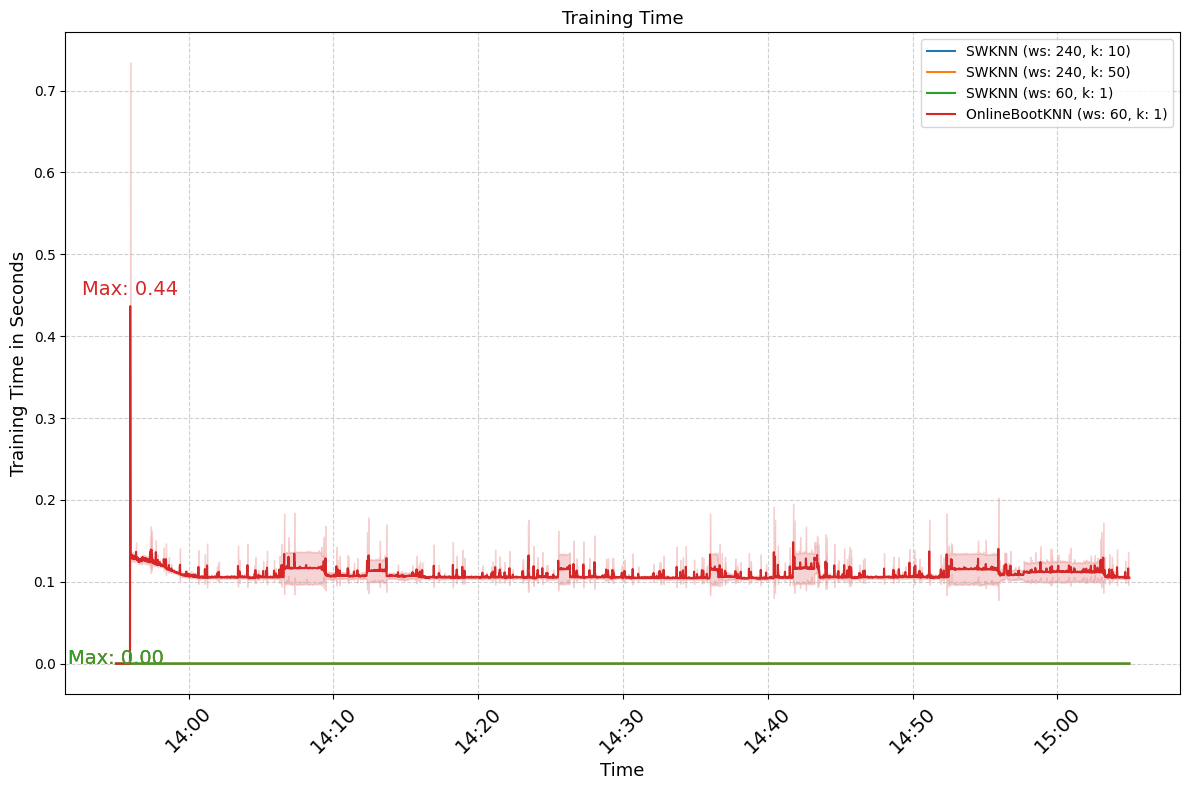

In [95]:
# Create a single figure
plt.figure(figsize=(12, 8))

# Group data by method and timestamp, calculating mean and standard deviation across iterations
grouped_data = filtered_data.groupby(['method_window_k', 'timestamp']).agg(
    mean_training_time_t=('training_time', 'mean'),
    std_training_time_t=('training_time', 'std')
).reset_index()


for m, color in zip(method_window_and_param, color_list):
    
    method_data = grouped_data[grouped_data["method_window_k"] == m]

    
    training_time = method_data['mean_training_time_t']

    # Plot averaged training time 
    plt.plot(
        method_data['timestamp'],
        training_time,
        label=f'{m}',
        color=color
    )

    # Plot shaded area representing standard deviation
    plt.fill_between(
        method_data['timestamp'],
        (method_data['mean_training_time_t'] - method_data['std_training_time_t']),
        (method_data['mean_training_time_t'] + method_data['std_training_time_t']),
        color=color,
        alpha=0.2
    )

    
    max_time = training_time.max()
    max_idx = training_time.idxmax()
    max_timestamp = method_data.loc[max_idx, 'timestamp']  # Ensuring correct index

    # Format the max value properly
    formatted_max_time = f"{max_time:,.2f}"  # Adds commas and rounds to 2 decimals

    # Annotate the max value
    plt.annotate(
        f'Max: {formatted_max_time}', 
        xy=(max_timestamp, max_time), 
        xytext=(max_timestamp, max_time * 1.03),  # Adjusted for better visibility
        #arrowprops=dict(facecolor=color, arrowstyle='->'),
        fontsize=FONTSIZE_MAIN,
        color=color,
        ha='center'
    )
# Format the x-axis to show only the hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Adding labels and title
plt.xlabel('Time', fontsize=FONTSIZE_SEC)
plt.ylabel('Training Time in Seconds', fontsize=FONTSIZE_SEC)
plt.legend(loc='best')  # Place legend dynamically
plt.title("Training Time", fontsize=FONTSIZE_SEC)
plt.xticks(rotation=45, fontsize=FONTSIZE_MAIN)
plt.grid(True, linestyle='--', alpha=0.6)  # Improve grid visibility
plt.tight_layout()

#plt.savefig(f"/home/nicolas/spectral_anomaly_detector/notebooks/img_training_and_scoring_time/{GLOBAL_SCENARIO_FILTER}_training_time.png", format="png")
# Display the plot
plt.show()


In [96]:
# Group by method and compute training time statistics
training_time_stats = filtered_data.groupby(['method_window_k', 'timestamp'])['training_time'].agg(
    mean_training_time_t='mean',
).reset_index()

training_time_stats = training_time_stats.groupby(['method_window_k'])['mean_training_time_t'].agg(
    mean_time='mean',
    median_time='median',
    min_time='min',
    max_time='max',
    std_dev_time='std'
).reset_index()

# Sort by mean training time in ascending order
training_time_stats = training_time_stats.sort_values(by='mean_time', ascending=True)

# Display summary
training_time_stats

,method_window_k,mean_time,median_time,min_time,max_time,std_dev_time
1,"SWKNN (ws: 240, k: 10)",0.000000,0.000000,0.000000,0.00000,0.000000
2,"SWKNN (ws: 240, k: 50)",0.000000,0.000000,0.000000,0.00000,0.000000
3,"SWKNN (ws: 60, k: 1)",0.000000,0.000000,0.000000,0.00000,0.000000
0,"OnlineBootKNN (ws: 60, k: 1)",0.107901,0.106115,0.000044,0.43665,0.015233


## Individual Scoring Time of Online Anomaly Detectors with PV Datasets 

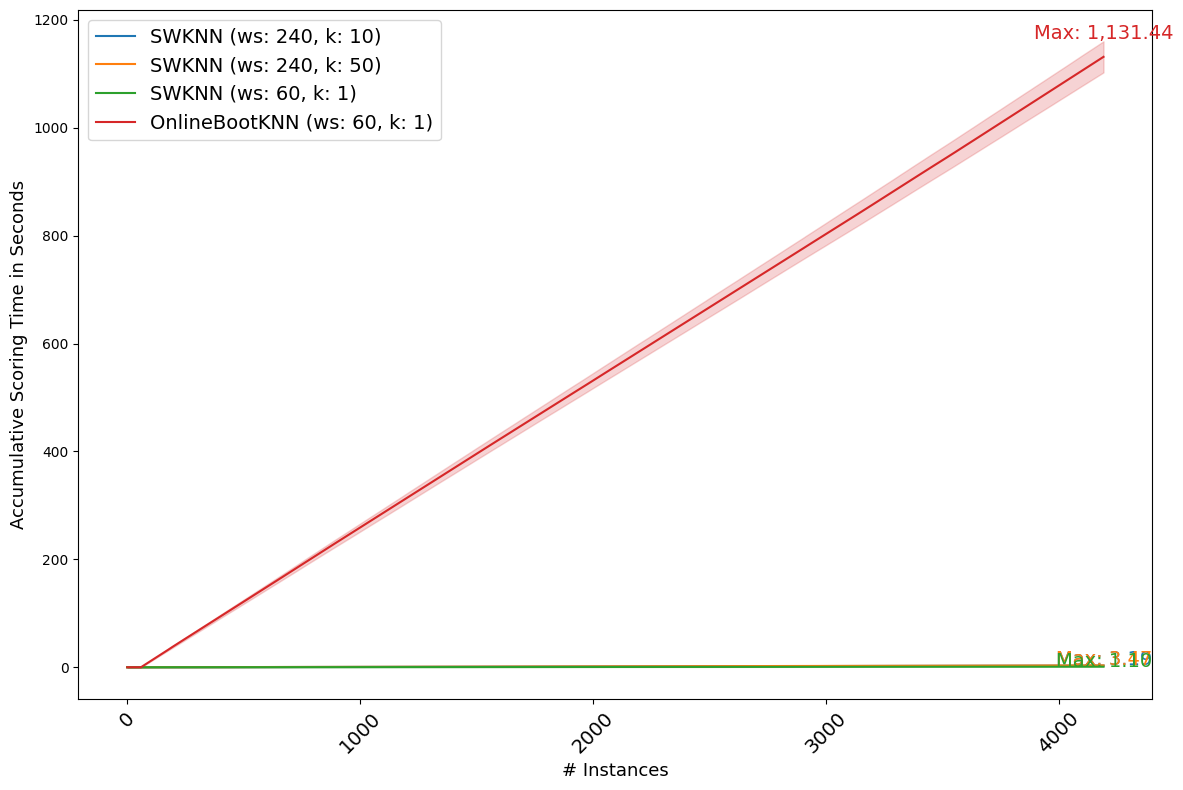

In [97]:
# Create a single figure
plt.figure(figsize=(12, 8))

# Group data by method and timestamp, calculating mean and standard deviation across iterations
grouped_data = filtered_data.groupby(['method_window_k', 'timestamp']).agg(
    mean_scoring_time_t=('scoring_time', 'mean'),
    std_scoring_time_t=('scoring_time', 'std')
).reset_index()

# Loop through methods and plot the accumulated values with shaded area
for m, color in zip(method_window_and_param, color_list):
    
    method_data = grouped_data[grouped_data["method_window_k"] == m]

    # Compute cumulative sum
    cumulative_training_time = method_data['mean_scoring_time_t'].expanding().sum()

    # Plot averaged training time with accumulation
    plt.plot(
        range(len(method_data['timestamp'])),  # Use the index as x-axis
        cumulative_training_time,
        label=f'{m}',
        color=color
    )

    # Plot shaded area representing standard deviation
    plt.fill_between(
        range(len(method_data['timestamp'])),  # Use the index as x-axis
        (method_data['mean_scoring_time_t'] - method_data['std_scoring_time_t']).expanding().sum(),
        (method_data['mean_scoring_time_t'] + method_data['std_scoring_time_t']).expanding().sum(),
        color=color,
        alpha=0.2
    )

    # Get max accumulated training time and timestamp
    max_time = cumulative_training_time.max()

    max_timestamp = len(method_data['timestamp'])  # Ensuring correct index

    # Format the max value properly
    formatted_max_time = f"{max_time:,.2f}"  # Adds commas and rounds to 2 decimals

    # Annotate the max value
    plt.annotate(
        f'Max: {formatted_max_time}', 
        xy=(max_timestamp, max_time), 
        xytext=(max_timestamp, max_time * 1.03),  # Adjusted for better visibility
        #arrowprops=dict(facecolor=color, arrowstyle='->'),
        fontsize=FONTSIZE_MAIN,
        color=color,
        ha='center'
    )

# Format the x-axis to show only the hours
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
# Adding labels and title
#plt.title("Scoring Time", fontsize=FONTSIZE_SEC)
plt.xlabel('# Instances', fontsize=FONTSIZE_SEC)
plt.ylabel('Accumulative Scoring Time in Seconds', fontsize=FONTSIZE_SEC)
plt.legend(loc='upper left', fontsize=FONTSIZE_MAIN)  # Place legend dynamically
plt.xticks(rotation=45, fontsize=FONTSIZE_MAIN)
#plt.grid(True, linestyle='--', alpha=0.6)  # Improve grid visibility
plt.tight_layout()

#plt.savefig(f"/home/nicolas/spectral_anomaly_detector/notebooks/img_training_and_scoring_time/{GLOBAL_SCENARIO_FILTER}_accum_scoring_time.pdf", format="pdf")
# Display the plot
plt.show()


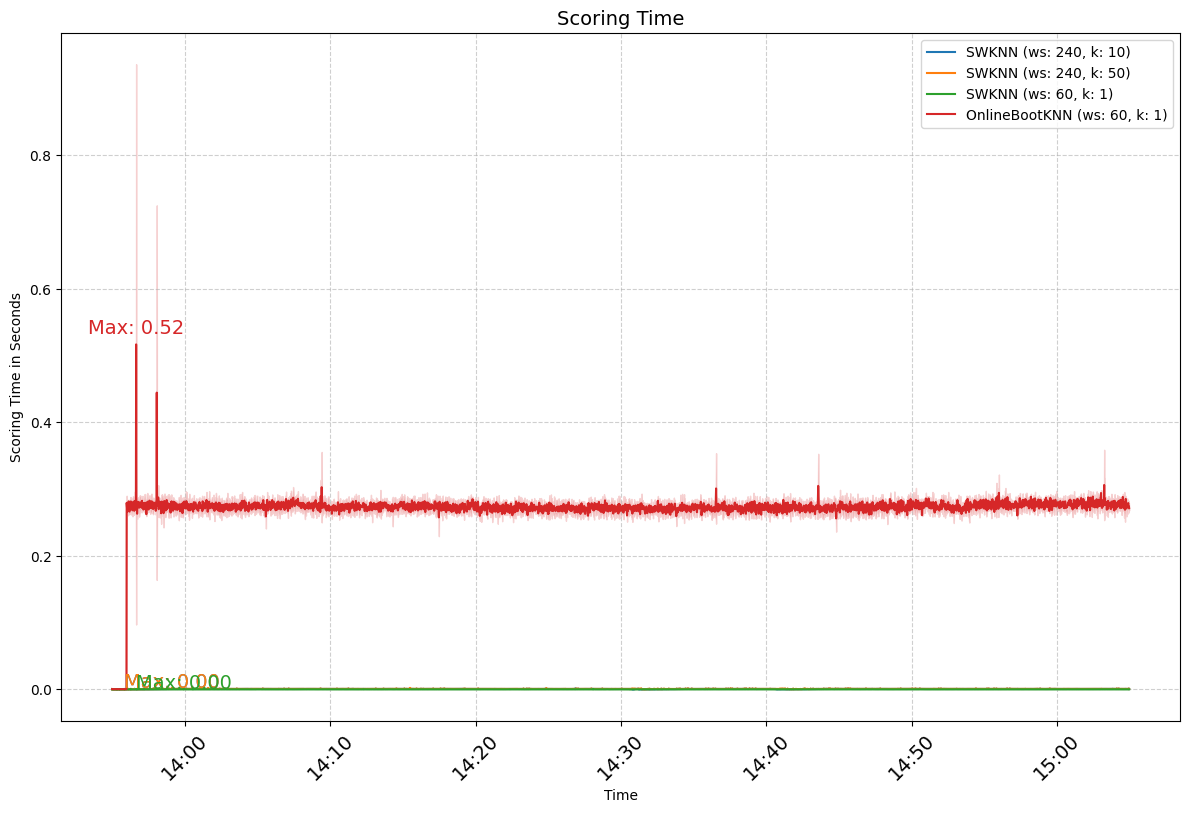

In [98]:
# Create a single figure
plt.figure(figsize=(12, 8))

# Group data by method and timestamp, calculating mean and standard deviation across iterations
grouped_data = filtered_data.groupby(['method_window_k', 'timestamp']).agg(
    mean_scoring_time_t=('scoring_time', 'mean'),
    std_scoring_time_t=('scoring_time', 'std')
).reset_index()


for m, color in zip(method_window_and_param, color_list):
    
    method_data = grouped_data[grouped_data["method_window_k"] == m]

    scoring_time = method_data['mean_scoring_time_t']

    plt.plot(
        method_data['timestamp'],
        scoring_time,
        label=f'{m}',
        color=color
    )

    # Plot shaded area representing standard deviation
    plt.fill_between(
        method_data['timestamp'],
        (method_data['mean_scoring_time_t'] - method_data['std_scoring_time_t']),
        (method_data['mean_scoring_time_t'] + method_data['std_scoring_time_t']),
        color=color,
        alpha=0.2
    )

    
    max_time = scoring_time.max()
    max_idx = scoring_time.idxmax()
    max_timestamp = method_data.loc[max_idx, 'timestamp']  # Ensuring correct index

    # Format the max value properly
    formatted_max_time = f"{max_time:,.2f}"  # Adds commas and rounds to 2 decimals

    # Annotate the max value
    plt.annotate(
        f'Max: {formatted_max_time}', 
        xy=(max_timestamp, max_time), 
        xytext=(max_timestamp, max_time * 1.03),  # Adjusted for better visibility
        #arrowprops=dict(facecolor=color, arrowstyle='->'),
        fontsize=FONTSIZE_MAIN,
        color=color,
        ha='center'
    )
# Format the x-axis to show only the hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Scoring Time in Seconds')
plt.legend(loc='best')  # Place legend dynamically
plt.xticks(rotation=45, fontsize=FONTSIZE_MAIN)
plt.grid(True, linestyle='--', alpha=0.6)  # Improve grid visibility
plt.tight_layout()
plt.title("Scoring Time", fontsize=FONTSIZE_MAIN)
#plt.savefig(f"/home/nicolas/spectral_anomaly_detector/notebooks/img_training_and_scoring_time/{GLOBAL_SCENARIO_FILTER}_scoring_time.png", format="png")
# Display the plot
plt.show()


In [100]:
# Group by method and compute scoring time statistics
scoring_time_stats = filtered_data.groupby(['method_window_k', 'timestamp'])['scoring_time'].agg(
    mean_scoring_time_t='mean',
).reset_index()

scoring_time_stats = scoring_time_stats.groupby(['method_window_k'])['mean_scoring_time_t'].agg(
    mean_time='mean',
    median_time='median',
    min_time='min',
    max_time='max',
    std_dev_time='std'
).reset_index()

# Sort by mean scoring time in ascending order
scoring_time_stats = scoring_time_stats.sort_values(by='mean_time', ascending=True)

# Display summary
scoring_time_stats

,method_window_k,mean_time,median_time,min_time,max_time,std_dev_time
3,"SWKNN (ws: 60, k: 1)",0.000263,0.000271,0.000056,0.000825,0.000040
1,"SWKNN (ws: 240, k: 10)",0.000761,0.000779,0.000046,0.002329,0.000167
2,"SWKNN (ws: 240, k: 50)",0.000827,0.000837,0.000054,0.002383,0.000163
0,"OnlineBootKNN (ws: 60, k: 1)",0.269840,0.273476,0.000454,0.516706,0.033108
